In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import pickle
import gc
import re
# ここから自作
import model
import result
import mode
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# 時刻を表示してくれるようになるprint関数のwrapper
def datePrint(*args, **kwargs):
    from datetime import datetime
    print(datetime.now().strftime('[%Y/%m/%d %H:%M:%S] '), end="")
    print(*args, **kwargs)

In [3]:
# datePrint("loading pickle data")
# input_val0 = pickle.load(open("../data/dna_len5_random256/input_test0.pkl","rb"))
# target_val0 = pickle.load(open("../data/dna_len5_random256/target_test0.pkl","rb")) #256のみ
# target_val0 = torch.flip(target_val0, dims=[1])
# input_train0 = pickle.load(open("../data/dna_len5_random256/input_train0.pkl","rb"))
# target_train0 = pickle.load(open("../data/dna_len5_random256/target_train0.pkl","rb")) #256以下
# target_train0 = torch.flip(target_train0, dims=[1])
# input_val1 = pickle.load(open("../data/dna_len5_random256/input_test1.pkl","rb"))
# target_val1 = pickle.load(open("../data/dna_len5_random256/target_test1.pkl","rb")) #256のみ
# target_val1 = torch.flip(target_val1, dims=[1])
# input_train1 = pickle.load(open("../data/dna_len5_random256/input_train1.pkl","rb"))
# target_train1 = pickle.load(open("../data/dna_len5_random256/target_train1.pkl","rb")) #256以下
# target_train1 = torch.flip(target_train1, dims=[1])
# input_val2 = pickle.load(open("../data/dna_len5_random256/input_test2.pkl","rb"))
# target_val2 = pickle.load(open("../data/dna_len5_random256/target_test2.pkl","rb")) #256のみ
# target_val2 = torch.flip(target_val2, dims=[1])
# input_train2 = pickle.load(open("../data/dna_len5_random256/input_train2.pkl","rb"))
# target_train2 = pickle.load(open("../data/dna_len5_random256/target_train2.pkl","rb")) #256以下
# target_train2 = torch.flip(target_train2, dims=[1])
# input_val3 = pickle.load(open("../data/dna_len5_random256/input_test3.pkl","rb"))
# target_val3 = pickle.load(open("../data/dna_len5_random256/target_test3.pkl","rb")) #256のみ
# target_val3 = torch.flip(target_val3, dims=[1])
# input_train3 = pickle.load(open("../data/dna_len5_random256/input_train3.pkl","rb"))
# target_train3 = pickle.load(open("../data/dna_len5_random256/target_train3.pkl","rb")) #256以下
# target_train3 = torch.flip(target_train3, dims=[1])
# input_val4 = pickle.load(open("../data/dna_len5_random256/input_test4.pkl","rb"))
# target_val4 = pickle.load(open("../data/dna_len5_random256/target_test4.pkl","rb")) #256のみ
# target_val4 = torch.flip(target_val4, dims=[1])
# input_train4 = pickle.load(open("../data/dna_len5_random256/input_train4.pkl","rb"))
# target_train4 = pickle.load(open("../data/dna_len5_random256/target_train4.pkl","rb")) #256以下
# target_train4 = torch.flip(target_train4, dims=[1])


# input_all = torch.cat([input_train0, input_val0, input_train1, input_val1, input_train2, input_val2, input_train3, input_val3, input_train4, input_val4], dim=0)
# target_all = torch.cat([target_train0, target_val0, target_train1, target_val1, target_train2, target_val2, target_train3, target_val3, target_train4, target_val4], dim=0)
# dataset = model.Dataset(input_all, target_all)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [900000, 100000])

# del input_val0, target_val0, input_train0, target_train0, input_val1, target_val1, input_train1, target_train1, input_val2, target_val2, input_train2, target_train2
# del input_val3, target_val3, input_train3, target_train3, input_val4, target_val4, input_train4, target_train4
# gc.collect()

In [4]:
# datePrint("loading pickle data")
# input_val0 = pickle.load(open("../data/max_span100_256/input_val0.pkl","rb"))
# target_val0 = pickle.load(open("../data/max_span100_256/target_val0.pkl","rb")) #256のみ
# target_val0 = torch.flip(target_val0, dims=[1])
# input_train0 = pickle.load(open("../data/max_span100_256/input_train0.pkl","rb"))
# target_train0 = pickle.load(open("../data/max_span100_256/target_train0.pkl","rb")) #256以下
# target_train0 = torch.flip(target_train0, dims=[1])
# input_val1 = pickle.load(open("../data/max_span100_256/input_val1.pkl","rb"))
# target_val1 = pickle.load(open("../data/max_span100_256/target_val1.pkl","rb")) #256のみ
# target_val1 = torch.flip(target_val1, dims=[1])
# input_train1 = pickle.load(open("../data/max_span100_256/input_train1.pkl","rb"))
# target_train1 = pickle.load(open("../data/max_span100_256/target_train1.pkl","rb")) #256以下
# target_train1 = torch.flip(target_train1, dims=[1])

# input_all = torch.cat([input_train0, input_val0, input_train1, input_val1], dim=0)
# target_all = torch.cat([target_train0, target_val0, target_train1, target_val1], dim=0)
# dataset = model.Dataset(input_all, target_all)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [1800000, 200000])

# del input_val0, target_val0, input_train0, target_train0, input_val1, target_val1, input_train1, target_train1
# gc.collect()

In [5]:
datePrint("loading pickle data")
input_val0 = pickle.load(open("../data/max_span100_512/input_val0.pkl","rb"))
target_val0 = pickle.load(open("../data/max_span100_512/target_val0.pkl","rb")) #512のみ
target_val0 = torch.flip(target_val0, dims=[1])
input_train0 = pickle.load(open("../data/max_span100_512/input_train0.pkl","rb"))
target_train0 = pickle.load(open("../data/max_span100_512/target_train0.pkl","rb")) #512以下
target_train0 = torch.flip(target_train0, dims=[1])
input_val1 = pickle.load(open("../data/max_span100_512/input_val1.pkl","rb"))
target_val1 = pickle.load(open("../data/max_span100_512/target_val1.pkl","rb")) #512のみ
target_val1 = torch.flip(target_val1, dims=[1])
input_train1 = pickle.load(open("../data/max_span100_512/input_train1.pkl","rb"))
target_train1 = pickle.load(open("../data/max_span100_512/target_train1.pkl","rb")) #512以下
target_train1 = torch.flip(target_train1, dims=[1])
input_val2 = pickle.load(open("../data/max_span100_512/input_val2.pkl","rb"))
target_val2 = pickle.load(open("../data/max_span100_512/target_val2.pkl","rb")) #512のみ
target_val2 = torch.flip(target_val2, dims=[1])
input_train2 = pickle.load(open("../data/max_span100_512/input_train2.pkl","rb"))
target_train2 = pickle.load(open("../data/max_span100_512/target_train2.pkl","rb")) #512以下
target_train2 = torch.flip(target_train2, dims=[1])
input_val3 = pickle.load(open("../data/max_span100_512/input_val3.pkl","rb"))
target_val3 = pickle.load(open("../data/max_span100_512/target_val3.pkl","rb")) #512のみ
target_val3 = torch.flip(target_val3, dims=[1])
input_train3 = pickle.load(open("../data/max_span100_512/input_train3.pkl","rb"))
target_train3 = pickle.load(open("../data/max_span100_512/target_train3.pkl","rb")) #512以下
target_train3 = torch.flip(target_train3, dims=[1])

# input_all = torch.cat([input_train0, input_val0, input_train1, input_val1])
# target_all = torch.cat([target_train0, target_val0, target_train1, target_val1])
input_all = torch.cat([input_train0, input_val0, input_train1, input_val1, input_train2, input_val2, input_train3, input_val3], dim=0)
target_all = torch.cat([target_train0, target_val0, target_train1, target_val1, target_train2, target_val2, target_train3, target_val3], dim=0)
dataset = model.Dataset(input_all, target_all)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [3500000, 500000])

del input_val0, target_val0, input_train0, target_train0, input_val1, target_val1, input_train1, target_train1
del input_val2, target_val2,  input_train2, target_train2, input_val3, target_val3, input_train3, target_train3
gc.collect()

[2021/04/29 02:26:43] loading pickle data


0

In [6]:
# datePrint("loading pickle data")
# input_val0 = pickle.load(open("../data/max_span100_1024/input_val01.pkl","rb"))
# target_val0 = pickle.load(open("../data/max_span100_1024/target_val01.pkl","rb")) #1024のみ
# target_val0 = torch.flip(target_val0, dims=[1])
# input_train0 = pickle.load(open("../data/max_span100_1024/input_train01.pkl","rb"))
# target_train0 = pickle.load(open("../data/max_span100_1024/target_train01.pkl","rb")) #1024以下
# target_train0 = torch.flip(target_train0, dims=[1])
# input_val1 = pickle.load(open("../data/max_span100_1024/input_val234.pkl","rb"))
# target_val1 = pickle.load(open("../data/max_span100_1024/target_val234.pkl","rb")) #1024のみ
# target_val1 = torch.flip(target_val1, dims=[1])
# input_train1 = pickle.load(open("../data/max_span100_1024/input_train234.pkl","rb"))
# target_train1 = pickle.load(open("../data/max_span100_1024/target_train234.pkl","rb")) #1024以下
# target_train1 = torch.flip(target_train1, dims=[1])
# input_all = torch.cat([input_train0, input_val0, input_train1, input_val1], dim=0)
# target_all = torch.cat([target_train0, target_val0, target_train1, target_val1], dim=0)
# dataset = model.Dataset(input_all, target_all)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [900000, 100000])

# del input_val0, target_val0, input_train0, target_train0, input_val1, target_val1, input_train1, target_train1
# gc.collect()

In [7]:
import math
def lambda_epoch(epoch):
    # スケジューラの設定
    max_epoch = 20
    return math.pow((1-epoch/max_epoch), 0.9)

[2021/04/29 02:27:26] 0 nani 0 layer
Epoch 1/20
train Loss:1.6719 Timer:3669.9891
val Loss:1.4833 Timer:192.0348
Epoch 2/20
train Loss:1.4445 Timer:3685.2054
val Loss:1.4231 Timer:190.2550
Epoch 3/20
train Loss:1.3987 Timer:3741.2511
val Loss:1.3893 Timer:161.3268
Epoch 4/20
train Loss:1.3758 Timer:3700.3478
val Loss:1.3739 Timer:197.1572
Epoch 5/20
train Loss:1.3612 Timer:3686.9358
val Loss:1.3647 Timer:281.9455


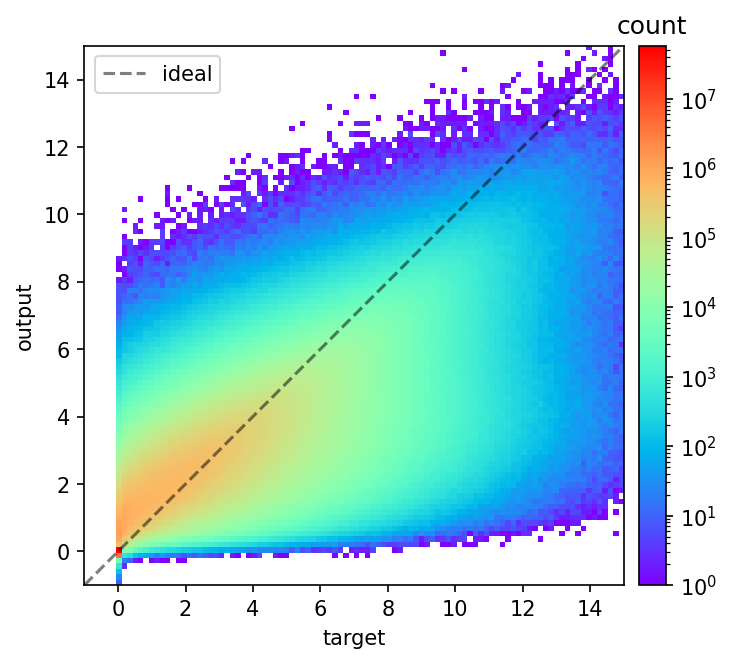

Epoch 6/20
train Loss:1.3510 Timer:3767.0901
val Loss:1.3529 Timer:190.1839
Epoch 7/20
train Loss:1.3431 Timer:2829.4155
val Loss:1.3436 Timer:95.0356
Epoch 8/20
train Loss:1.3366 Timer:2614.0535
val Loss:1.3444 Timer:93.5664
Epoch 9/20
train Loss:1.3312 Timer:2619.1864
val Loss:1.3370 Timer:93.1366
Epoch 10/20
train Loss:1.3268 Timer:2609.7356
val Loss:1.3297 Timer:134.5720


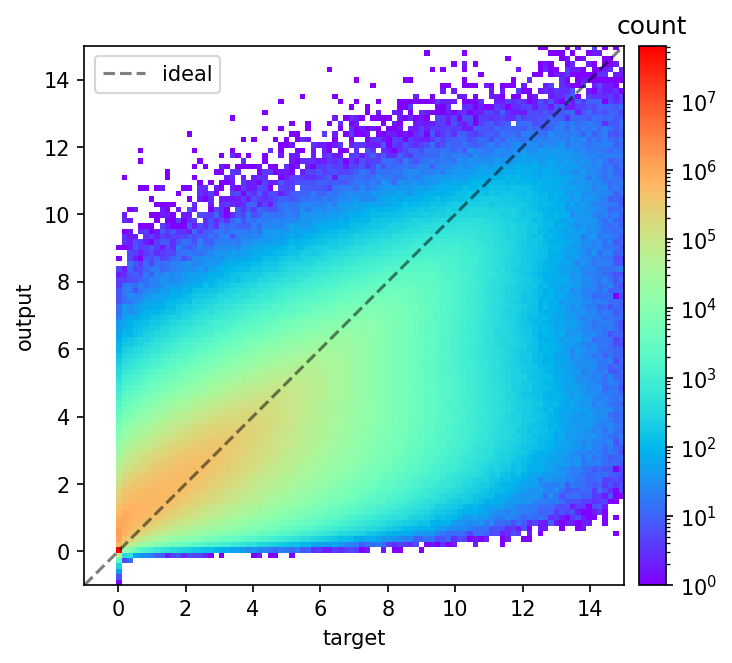

Epoch 11/20
train Loss:1.3228 Timer:2623.8535
val Loss:1.3304 Timer:94.0052
Epoch 12/20
train Loss:1.3193 Timer:2621.7272
val Loss:1.3236 Timer:93.2621
Epoch 13/20
train Loss:1.3162 Timer:2623.1644
val Loss:1.3233 Timer:93.5266
Epoch 14/20
train Loss:1.3136 Timer:2622.0764
val Loss:1.3195 Timer:93.7307
Epoch 15/20
train Loss:1.3110 Timer:2625.3539
val Loss:1.3148 Timer:131.9114


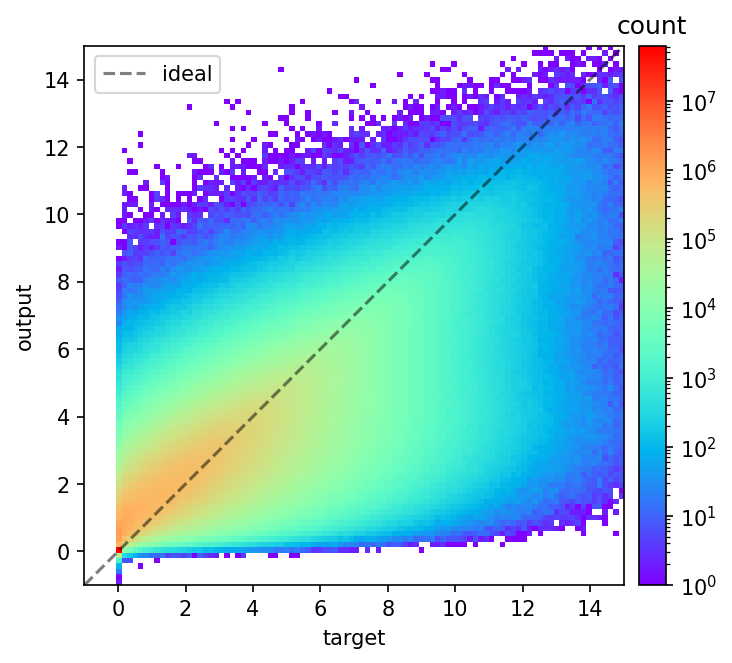

Epoch 16/20
train Loss:1.3090 Timer:2628.9110
val Loss:1.3139 Timer:93.5496
Epoch 17/20
train Loss:1.3070 Timer:2614.6739
val Loss:1.3135 Timer:92.5323
Epoch 18/20
train Loss:1.3052 Timer:2614.4706
val Loss:1.3174 Timer:94.7723
Epoch 19/20
train Loss:1.3035 Timer:2619.8766
val Loss:1.3127 Timer:94.1329
Epoch 20/20
train Loss:1.3020 Timer:2609.5926
val Loss:1.3158 Timer:134.7300


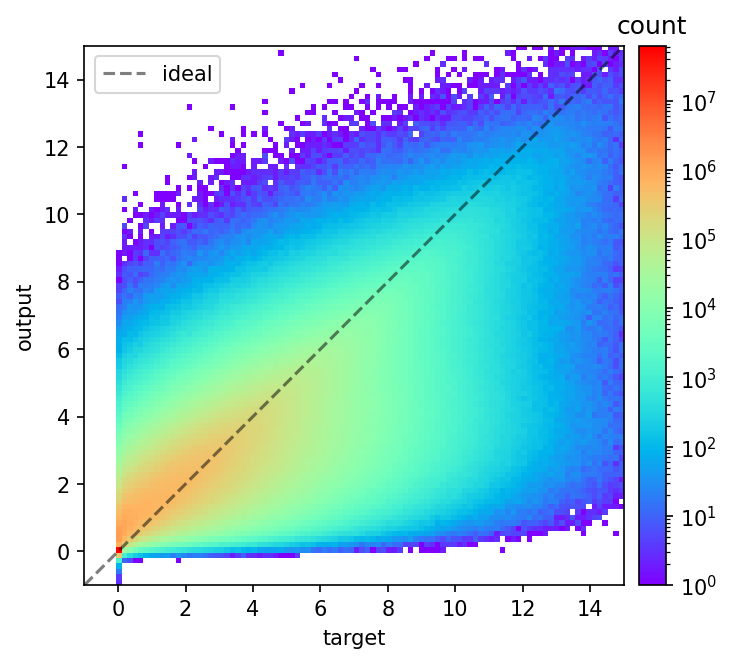

num_layer=16, kernel_sizes=33


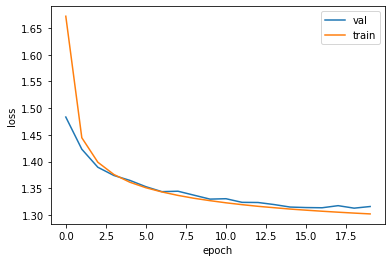

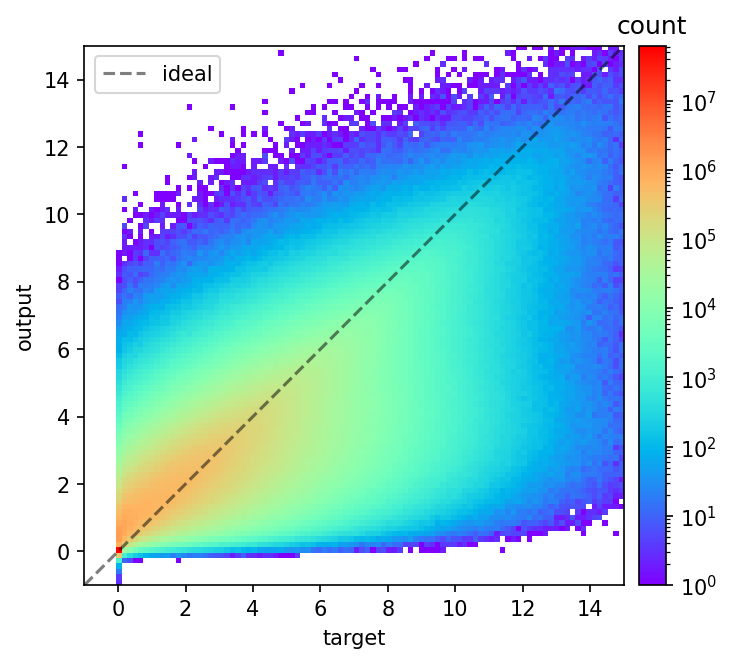

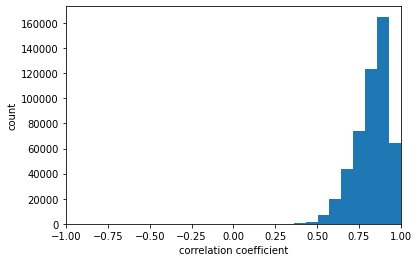

0.8273455010632755


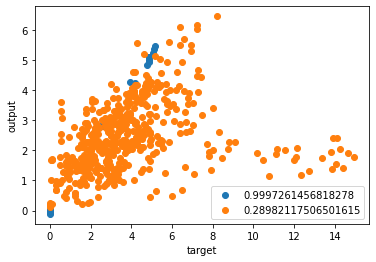

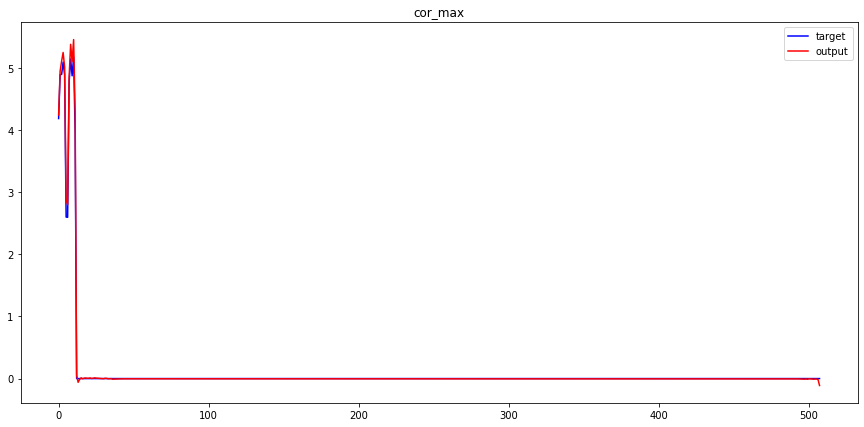

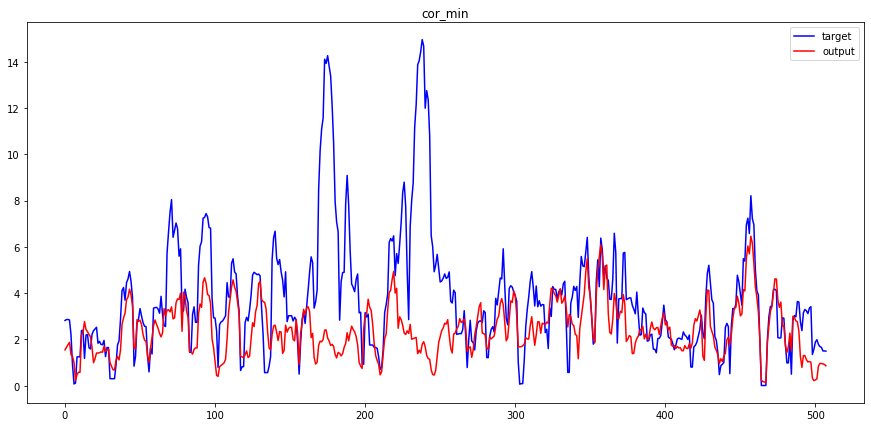

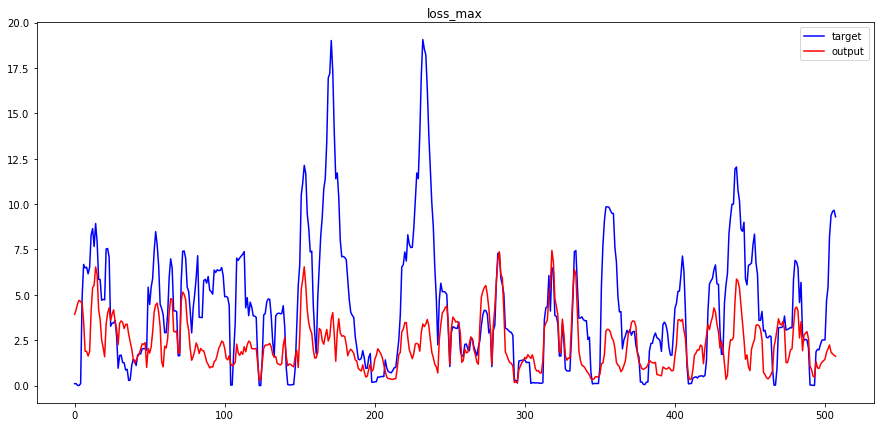

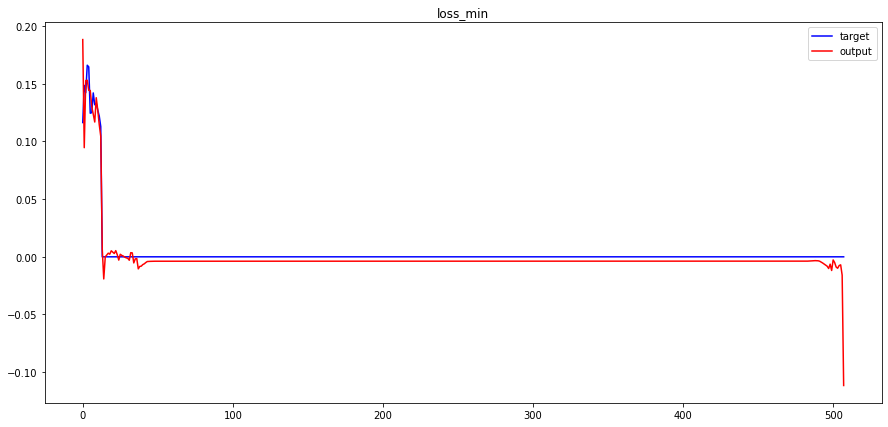

cor_max AAUGCGCCGGCGCACG
cor_min CAGCCUCAACAAGCAGAGCAACAGUCCAGACCAGUUAUUCUAGAGGAGCGUCUUCUUUAUCGGGCUCAAGGCGUAGGCGUCGCGCAAACGCAAGCGGCUCGAUUAAAGUCUACGGGCCAAGUGUUCAAGCCGUGGUUGAUGUGCCUACUAUCUCUAUGGAAUAGAGUUUGUUUGCUUGUCAUGAUUUGUCUCCUGCAGUACUAGCGGUUUAUAUAUGGACGCGGUGAGGACAGGCAUGACGAGCGAAUAAAUGGUCCUUUCUAGUGAGAUGUUUUUGCGACUUUAUAGUACGGGGGGUUGCCAGUUAUUGUGAAGGCUUCAGGUGGACGGCAACGGCGAUGGACUAUCCGCGGUGUACCCGGUUGGUCAACUGGAAGCUUUUAAGCCGAGAGAUGGAAGCAGUCGGAUUUGAGUUACGUGAAAGGGUCUCGCCUUUAUAUUCGAUGAUCGGUGGUGGUGCUGGUUCUAGAUUACCUGCACAAGCUCCUGGCAAGUACCAAUCAAAAGGCUAA
loss_max AGGCCCGACGCACGGCGGGUGAGCACCGAGGUGAUUGGGUUAGAUAUCGGACAGAUGGGUAGAACCAGCCACCGGGCUCUUCCAUCCAUCGUUUACAGUCGUGCAAUUGAUCGCUCAGAAUCUUACAUUAGAUCUAUUCCCAACGUUCUUAUGGGGAGCGAAUGCUGGCACCCGAGCUUCGGAACGCGAUAUCAAUUCAAUGACGGGAAAAGAAAAAUAUCCGCUUCUGCAGCUCGGGUGUCACAAUGGGUCCUGCCCUCGAACGGUCGUUAAGCCCGCAAAGCGGGGAUAGCAAAAAAAGUUCUCCUAGUUACAUCGGCGAGAGUCCUCUAGCCGGCUCUCCCAAUCUUUUCAUGCCGCUCUUGAUCGAAAAGCGCCACCUGACUAGUUCUUUUUCUAAACCCGGGCAGAUAAUAUGCGAGCAGUGCCCGUUUAGCCAGGAGCG

In [8]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

for n in [0]:
    for x in [0]:
        datePrint(n, 'nani', x, 'layer')
        net = model.Variable(num_layer=8, kernel_sizes=9, flag=[1,2,3,2]).to(device)
        net.apply(model.weight_init) #重みの初期化適用
        #ファインチューニング
#         optimizer = optim.Adam([{'params': net.embedding.parameters(), 'lr': 5e-4},
#                                 {'params': net.convs.parameters(), 'lr': 1e-4},
#                                 {'params': net.mid.parameters(), 'lr': 5e-4},
#                                 {'params': net.fc.parameters(), 'lr': 1e-3}], weight_decay=1e-6)
        optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-6, eps=1e-5)
        epochs = 20
        criterion = nn.MSELoss().to(device)
#         # 学習途中データ
#         checkpoint = torch.load('max_span100.pth')
#         net.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epochs = checkpoint['epoch']
#         loss = checkpoint['loss']
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)
        train_loss_list, val_loss_list, data_all, target_all, output_all = mode.train(device, net, dataloaders_dict, criterion, optimizer, epochs)               
        torch.save(net.state_dict(), 'max_span100.pth')
    
        print(f'num_layer=16, kernel_sizes=33')
        
        result.learning_curve(train_loss_list, val_loss_list, epochs)
        result.plot_result(np.array(target_all, dtype=object).reshape(-1), np.array(output_all, dtype=object).reshape(-1))
        cor_list, loss_list = result.cal_indicators(target_all, output_all)
        result.cor_hist(cor_list)
        result.scatter_minmax(cor_list, loss_list, target_all, output_all)
        result.visible_minmax(target_all, output_all, cor_list, loss_list)
        result.show_base(data_all, cor_list, loss_list)

random= 469690


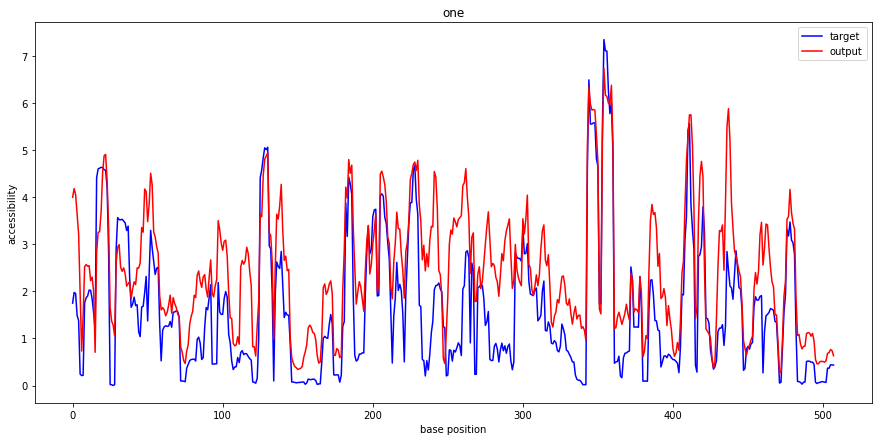

random= 241096


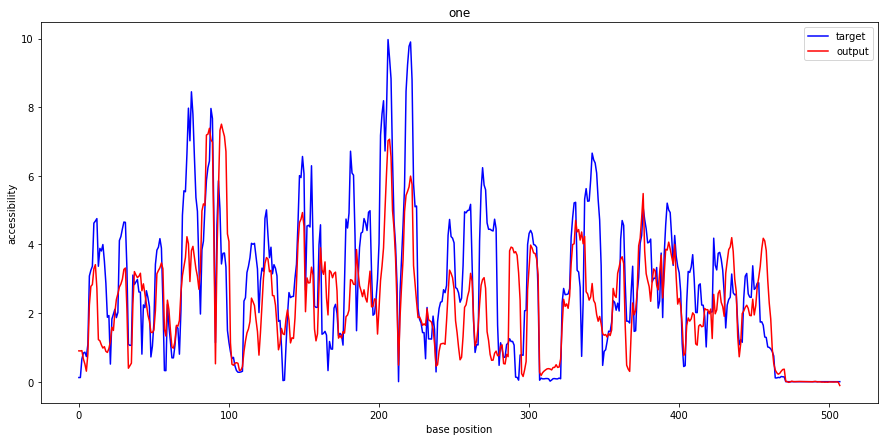

random= 132045


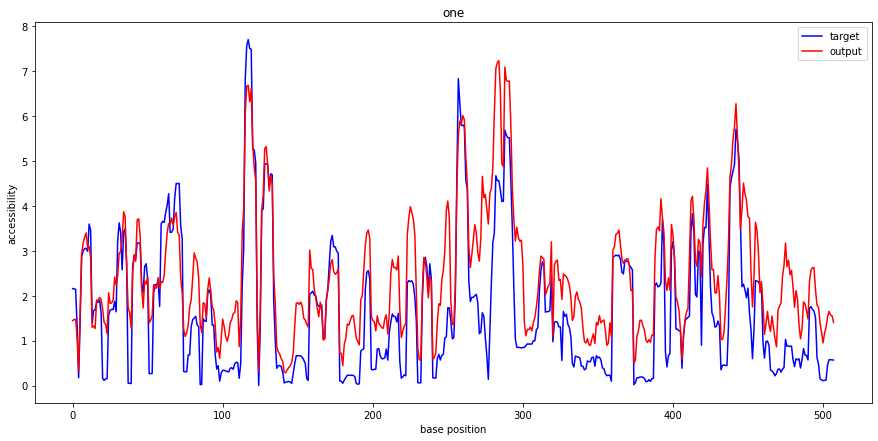

random= 117623


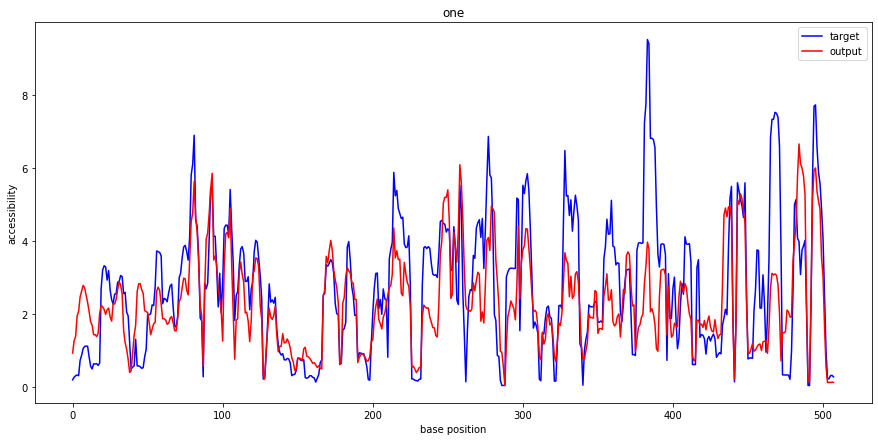

In [9]:
for i in range(4):
    result.visible_one(target_all, output_all)

In [10]:
# input_test = pickle.load(open("../data/test_sets/input_600_1000.pkl","rb"))
# target_test = pickle.load(open("../data/test_sets/target_600_1000.pkl","rb"))
input_test = pickle.load(open("../data/RF00156/input_RF00156.pkl","rb"))
target_test = pickle.load(open("../data/RF00156/target_RF00156.pkl","rb"))
target_test = torch.flip(target_test, dims=[1])
datePrint(input_test.shape)
datePrint(target_test.shape)
transform = False
# if (input_test.shape[1]%256 != 0):
#     input_test = F.pad(input_test, (0, 256-input_test.shape[1]%256))
#     target_test = F.pad(target_test, (0, 252-target_test.shape[1]%256))
# if (input_test.shape[1]>256):
#     transform = True
#     division = (input_test.shape[1])//128 - 1
#     input_init = input_test
#     input_test = input_test.unfold(1, 256, 128).reshape(-1, 256)
#     target_test = target_test.unfold(1, 252, 128).reshape(-1, 252)
# else:
#     transform = False
# datePrint(input_test.shape)
# datePrint(target_test.shape)
test_dataset = model.Dataset(input_test, target_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,shuffle=False, num_workers=1)

net = model.Variable(num_layer=16, kernel_sizes=33, flag=False).to(device)
net.load_state_dict(torch.load('max_span20.pth'))
criterion = nn.MSELoss().to(device)

start = time.time()
test_loss, data_all, target_all, output_all = mode.test(device, net, test_dataloader, criterion) 
datePrint('finish prediction loss', test_loss)
if (transform==True):
    target_tmp = torch.tensor(target_all)
    output_tmp = torch.tensor(output_all)
    output_tmp = F.relu(output_tmp)
    for n in range(division):
        if (n==0):
            target_all = target_tmp[n::division, :192]
            output_all = output_tmp[n::division, :192]
        elif (n==division-1):
            target_all = torch.cat([target_all, target_tmp[n::division, 64:]], dim=1)
            output_all = torch.cat([output_all, output_tmp[n::division, 64:]], dim=1)
        else:
            target_all = torch.cat([target_all, target_tmp[n::division, 64:192]], dim=1)
            output_all = torch.cat([output_all, output_tmp[n::division, 64:192]], dim=1)
    
    data_all = input_init.numpy()
    target_all = target_all.numpy()
    output_all = output_all.numpy()
finish = time.time()
np.savetxt('accessibility_output.txt', output_all, fmt='%.3e')
finish = time.time()
datePrint('予測時間', (finish-start))

[2021/04/29 19:42:24] torch.Size([1332, 256])
[2021/04/29 19:42:24] torch.Size([1332, 252])
[2021/04/29 19:42:26] finish prediction loss 0.04002361593856698
[2021/04/29 19:42:26] 予測時間 1.3703727722167969


[2021/04/29 19:42:26] test_loss: 0.040


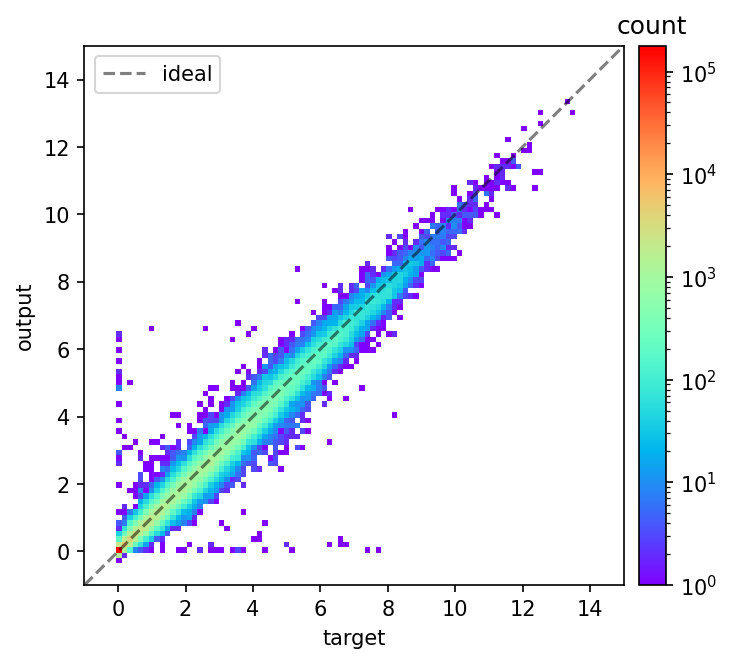

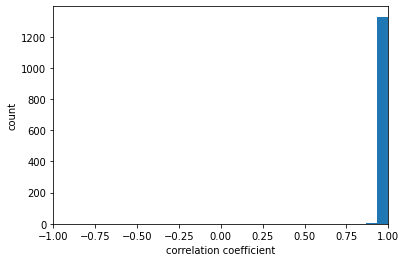

0.9940039630814775


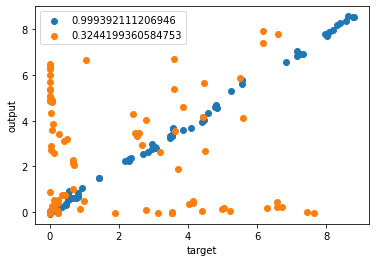

In [11]:
datePrint('test_loss: {:.3f}'.format(test_loss))
result.plot_result(np.array(target_all).reshape(-1), np.array(output_all).reshape(-1))
cor_list, loss_list = result.cal_indicators(target_all, output_all)
result.cor_hist(cor_list)
result.scatter_minmax(cor_list, loss_list, target_all, output_all)

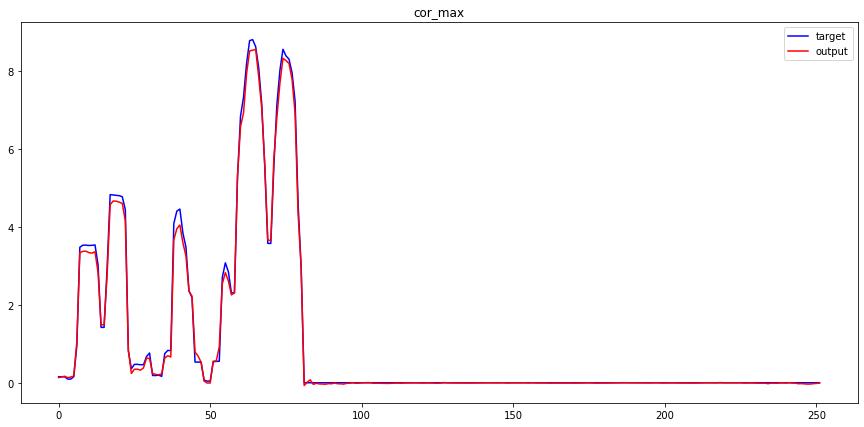

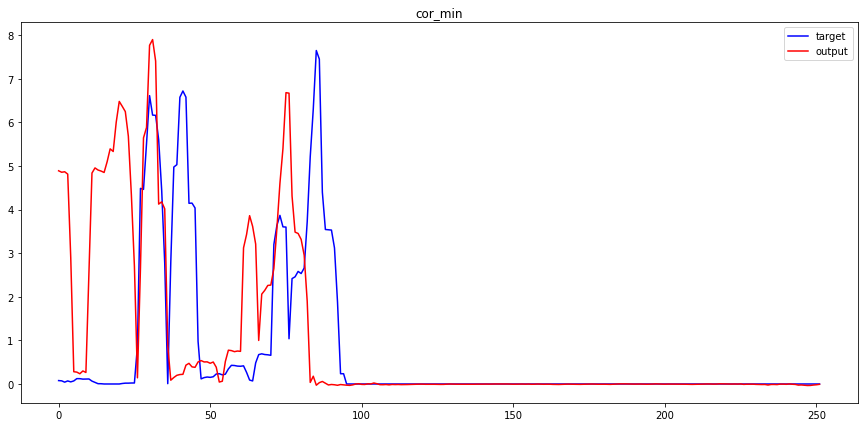

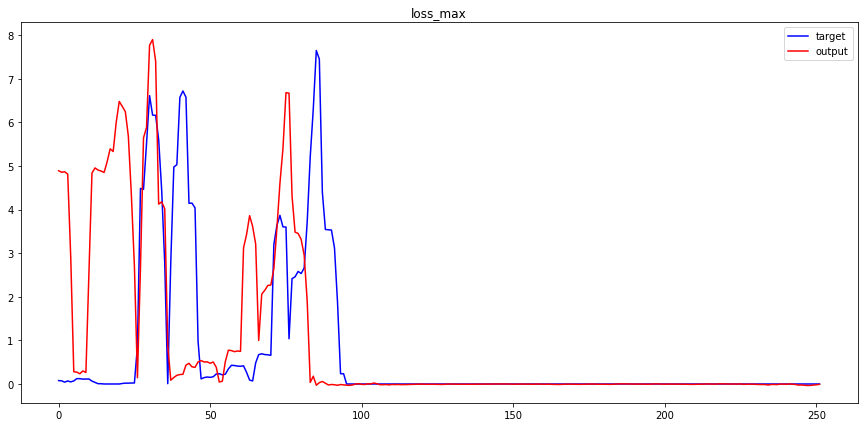

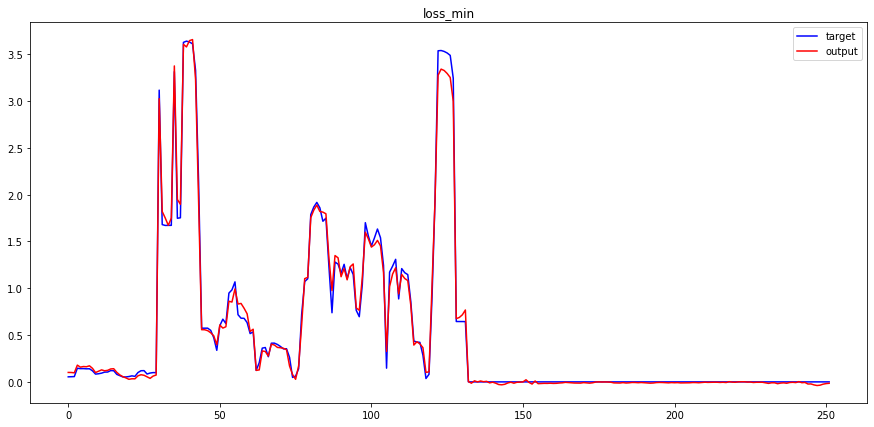

cor_max AAGACCCUUCAGCUGCAACCAGCUUCCUUGUUAGUGUGUGCAGCCUGUUUCUUGUAUUGGCUGCUCUAAGGGACCUUGGAGAUAGAC
cor_min CUGCCUCGAAGUCUGGCAAUGGCUGCAAACAGCAGCUUCCUUGGUAGUGUUCUUUGUAUGGGUUGCUCUAAGGGACCUUGGAGACAGGC
loss_max CUGCCUCGAAGUCUGGCAAUGGCUGCAAACAGCAGCUUCCUUGGUAGUGUUCUUUGUAUGGGUUGCUCUAAGGGACCUUGGAGACAGGC
loss_min AUGAAAAGAAACUAUCCAGCCCAUUCUCCUUUUAGCCAUAAGGCCCAGUAUUCAGUGACUACAAACAAGCAGCUUCCUAUUAGUGUACACAGUACCUUGUUUGUAUGAGUUGCACCAAAAGACCUUGGAAACAGAC


In [12]:
result.visible_minmax(target_all, output_all, cor_list, loss_list)
result.show_base(data_all, cor_list, loss_list)

random= 489


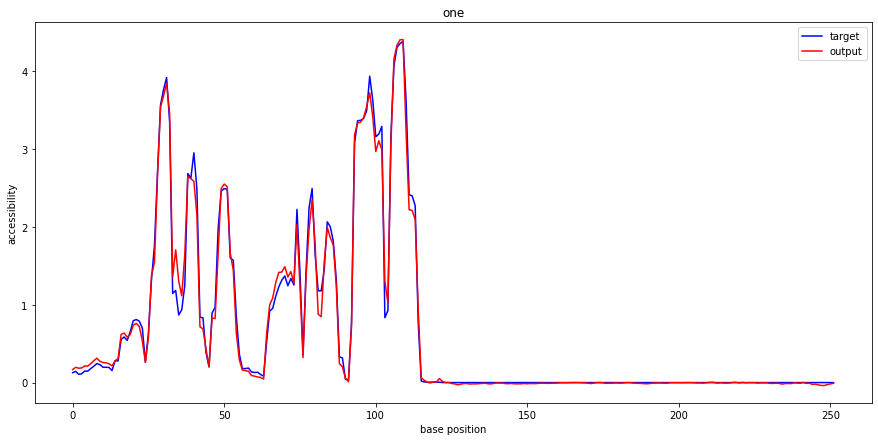

random= 270


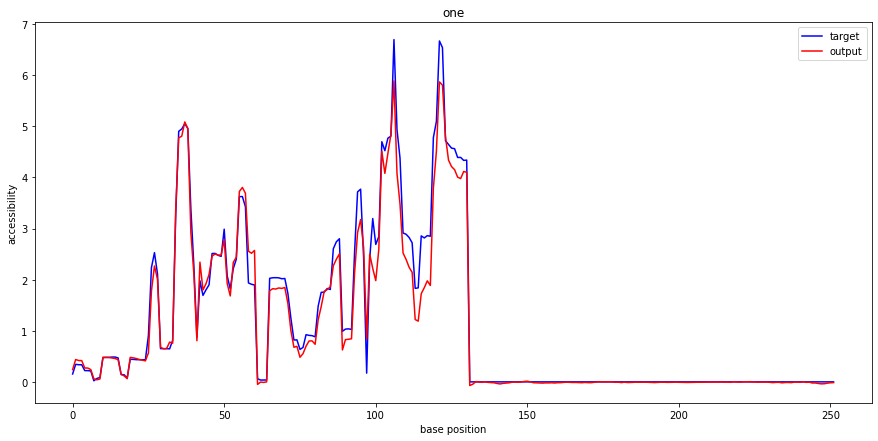

random= 266


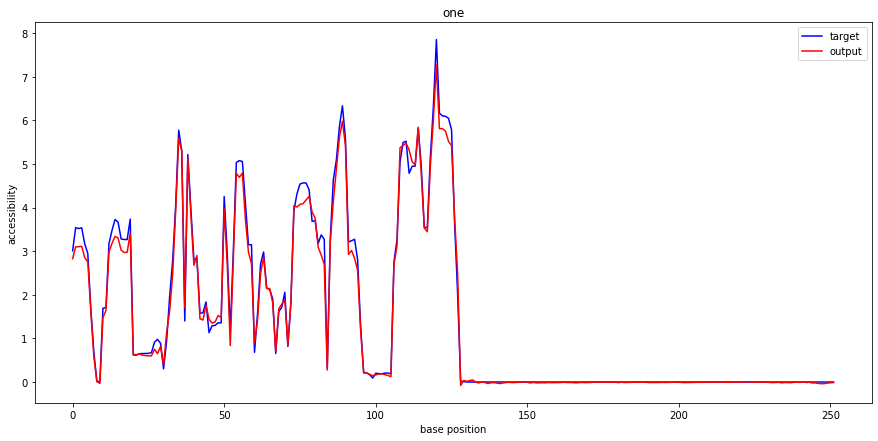

random= 617


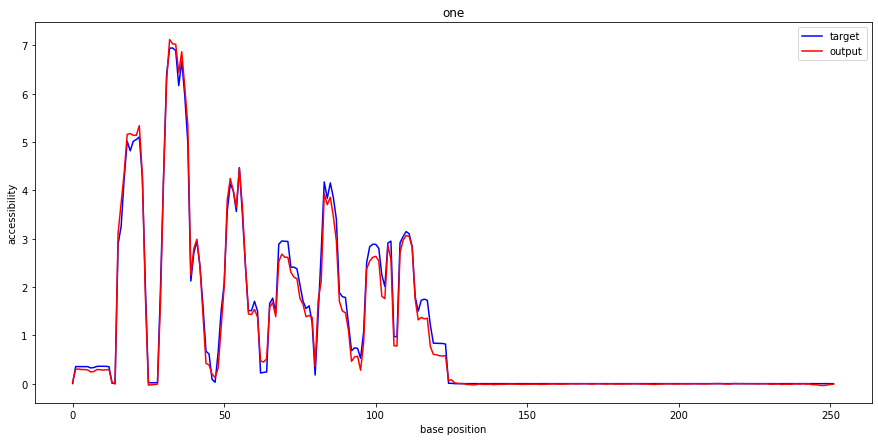

In [13]:
for i in range(4):
    result.visible_one(target_all, output_all)

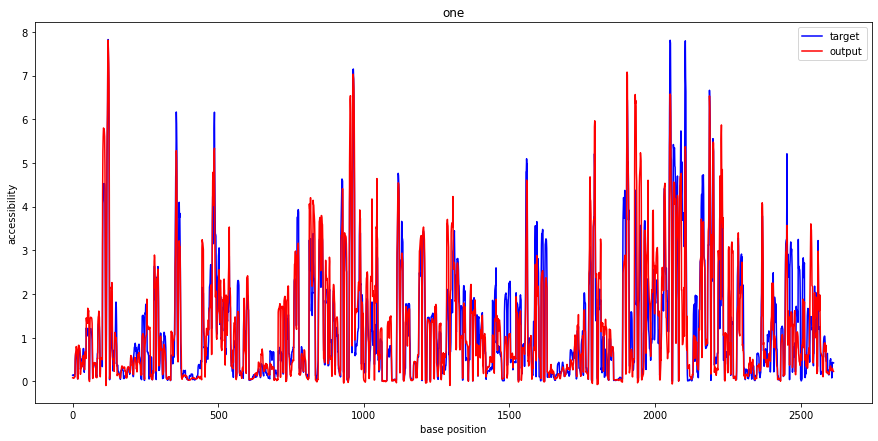

cor 0.8985274347559651
mse 0.3695233777596883
[2021/04/29 19:42:30] 予測時間 1.7689337730407715


In [14]:
start = time.time()
path = "../data/human_data/seq7.fa"
with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]
name = seq_file[0]
seq = ''.join(seq_file[1:]).replace('A', '1').replace('T', '2').replace('U', '2').replace('G', '3').replace('C', '4')
input_seq = torch.Tensor(list(map(int, seq)))
input_seq = torch.flip(input_seq, dims=[0])
input_seq = input_seq.unsqueeze(0)
out_length = len(input_seq[0])-4

transform = False
# if (input_seq.shape[1]%256 != 0):
#     input_seq = F.pad(input_seq, (0, 256-input_seq.shape[1]%256))
# if (input_seq.shape[1]>256):
#     transform = True
#     division = (input_seq.shape[1])//128 - 1
#     input_init = input_seq
#     input_seq = input_seq.unfold(1, 256, 128).reshape(-1, 256)
# else:
#     transform = False
input_seq = input_seq.unsqueeze(0)

net = model.Variable(num_layer=16, kernel_sizes=33, flag=False).to(device)
net.load_state_dict(torch.load('max_span20.pth'))
    
data_all, output_all = mode.predict(device, net, input_seq) 

if (transform==True):
    output_tmp = torch.tensor(output_all)
    for n in range(division):
        if (n==0):
            output_all = output_tmp[n::division, :192]
        elif (n==division-1):
            output_all = torch.cat([output_all, output_tmp[n::division, 64:]], dim=1)
        else:
            output_all = torch.cat([output_all, output_tmp[n::division, 64:192]], dim=1)
    
    data_all = input_init.numpy()
#     output_all = torch.flip(output_all, dims=[1])
    output_all = output_all.numpy()
  
import matplotlib.pyplot as plt
max_length = output_all.shape[1]
with open('../data/human_data/out7.txt', 'r') as f:
        next(f)
        acc = f.readlines()
        acc_list = []
        for i in range(len(acc)-1):
                acc_list.append(re.findall(',(.*);', acc[i])[0])
acc_list = [float(x) for x in acc_list]

plt.figure(figsize=(15, 7))
plt.plot(range(out_length), acc_list, label='target', color='b')
plt.plot(range(out_length), output_all[0][:out_length], label='output', color='r')
plt.legend()
plt.xlabel('base position')
plt.ylabel('accessibility')
plt.title('one')
plt.show()


cor = np.corrcoef(acc_list, output_all[0][:out_length])
mse = ((acc_list - output_all[0][:out_length])**2).mean(axis=0)
print('cor', cor[0,1])
print('mse', mse)

    
np.savetxt('accessibility_output.txt', output_all, fmt='%.3f')
finish = time.time()
datePrint('予測時間', (finish-start))

In [15]:
path = "../data/real_data/RF00156.fa"

start = time.time()
with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]
name_list = []
seq_list = torch.empty(0, 256)

for i in range(len(indexes)-1):
    name_list.append(seq_file[indexes[i]])
    seq = ''.join(seq_file[indexes[i]+1:indexes[i+1]]).replace('A', '1').replace('T', '2').replace('U', '2').replace('G', '3').replace('C', '4').replace('N', '0')
    seq = torch.Tensor(list(map(int, seq)))
    seq = torch.flip(seq, dims=[0])
    if (seq.shape[0]%256 != 0):
        seq = F.pad(seq, (0, 256-seq.shape[0]%256))
    seq = seq.unsqueeze(0)
    seq_list = torch.cat([seq_list, seq], dim=0)


# if (input_seq.shape[1]%256 != 0):
#     input_seq = F.pad(input_seq, (0, 256-input_seq.shape[1]%256))
# if (input_seq.shape[1]>256):
#     transform = True
#     division = (input_seq.shape[1])//128 - 1
#     input_init = input_seq
#     input_seq = input_seq.unfold(1, 256, 128).reshape(-1, 256)
# else:
#     transform = False
# datePrint(input_seq.shape)
# input_seq = input_seq.unsqueeze(0)
# datePrint(input_seq.shape)

seq_list = seq_list.unsqueeze(0)
net = model.Variable(num_layer=16, kernel_sizes=33, flag=False).to(device)
net.load_state_dict(torch.load('max_span20.pth'))
    
data_all, output_all = mode.predict(device, net, seq_list) 
# if (transform==True):
#     output_tmp = torch.tensor(output_all)
#     for n in range(division):
#         if (n==0):
#             output_all = output_tmp[n::division, :192]
#         elif (n==division-1):
#             output_all = torch.cat([output_all, output_tmp[n::division, 64:]], dim=1)
#         else:
#             output_all = torch.cat([output_all, output_tmp[n::division, 64:192]], dim=1)
    
#     data_all = input_init.numpy()
#     output_all = output_all.numpy()
    
np.savetxt('accessibility_output.txt', output_all, fmt='%.3f')
finish = time.time()
datePrint('予測時間', (finish-start))

FileNotFoundError: [Errno 2] No such file or directory: '../data/real_data/RF00156.fa'

In [ ]:
# sample作成
path = "../data/RF01210/RF01210.fa"

with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]

for i in range(len(indexes)-1):
    with open(f"../data/RF01210/sample_{i}.txt", mode="w") as f:
        f.write(seq_file[indexes[i]] + "\n")
        f.write(''.join(seq_file[indexes[i]+1:indexes[i+1]]))

In [ ]:
# castしちゃう
from pathlib import Path
import numpy as np
from tqdm import tqdm
import pickle
import torch
import sys

for cond, cnt in (("train", 500000), ("test", 500000)):
    data_path = Path(f"../data/makedata/{cond}")
    input_array = []
    target_array = []
    print(f"reading {cond} files")
    for i in tqdm(range(cnt)):
        input_path = data_path / f"index/input_{i+1}.csv"
        target_path = data_path / f"accessibility/target_{i+1}.csv"

        input_array.append(torch.Tensor(np.loadtxt(input_path, delimiter=",", dtype=np.float).astype(np.int)))
        target_array.append(torch.Tensor(np.loadtxt(target_path, delimiter=",", dtype=np.float)))
    print(f"saving to input_{cond}.pkl")
    pickle.dump(torch.stack(input_array), open(f"../data/input_{cond}.pkl", 'wb'))
        
    print(f"saving to target_{cond}.pkl")
    pickle.dump(torch.stack(target_array), open(f"../data/target_{cond}.pkl", 'wb'))


In [ ]:
#メモリ確認
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #10M以上のみ表示
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))